# Noise Reduction

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/noise-reduction](https://github.com/huseinzol05/malaya-speech/tree/master/example/noise-reduction).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on English, Manglish and Bahasa podcasts with augmented noises, gathered at https://github.com/huseinzol05/malaya-speech/tree/master/data/podcast

Purpose of this module to reduce background musics, noises and etc.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.load('speech/podcast/SKOLAR.wav', sr = 44100)
len(y), sr, len(y) / sr

(2628043, 44100, 59.59281179138322)

So total length is 60 seconds.

In [3]:
import IPython.display as ipd
ipd.Audio(y[:10 * sr], rate = sr)

This audio extracted from https://www.youtube.com/watch?v=blaIfSWf38Q&t=25s&ab_channel=SkolarMalaysia

As you can hear, the audio got introduction music overlapped with speakers. So we want to reduce that introduction music and possibly split the audio into voice and background noise.

### List available deep model

In [2]:
malaya_speech.noise_reduction.available_model()

INFO:root:Only calculate SDR, ISR, SAR on voice sample. Higher is better.


Size (MB)  Quantized Size (MB)   SUM MAE  MAE_SPEAKER  MAE_NOISE  \
unet              78.9                 20.0  0.860744      0.56171   0.299029   
resnet-unet       96.4                 24.6  0.813386      0.53433   0.279050   

                  SDR        ISR        SAR  
unet         8.512531  13.411639  11.407554  
resnet-unet  8.806321  13.517500  11.752460

### Load deep model

In [20]:
model = malaya_speech.noise_reduction.deep_model(model = 'resnet-unet')

### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [19]:
quantized_model = malaya_speech.noise_reduction.deep_model(model = 'resnet-unet', quantized = True)

### Important factor

1. Noise Reduction model trained on 44k sample rate, so make sure load the audio with 44k sample rate.

```python
malaya_speech.load(audio_file, sr = 44100)
librosa.load(audio_file, sr = 44100)
```

2. You can feed dynamic length of audio, no need to cap, the model do padding by itself. But again, the longer the audio, the longer time required to calculate, unless you have GPU to speed up.
3. STFT and Inverse STFT can be done on GPU level, so the model is really fast on GPU.

In [6]:
%%time

output = model(y)

CPU times: user 27.2 s, sys: 3.61 s, total: 30.8 s
Wall time: 6.07 s


In [7]:
output

{'voice': array([ 7.4655384e-07, -5.3525662e-07, -3.8191757e-07, ...,
        -3.0058224e-02, -2.9105157e-02, -2.1171883e-02], dtype=float32),
 'noise': array([-4.3224041e-08, -2.3430280e-06, -3.2800205e-07, ...,
        -1.3801644e-03, -3.3497461e-03, -1.9985531e-03], dtype=float32)}

In [8]:
ipd.Audio(output['voice'][:10 * sr], rate = sr)

In [9]:
ipd.Audio(output['noise'][:10 * sr], rate = sr)

Nicely done! How about our quantized model?

In [17]:
%%time

output_quantized = quantized_model(y)
output_quantized

CPU times: user 27.2 s, sys: 3.46 s, total: 30.7 s
Wall time: 5.85 s


{'voice': array([        nan,         nan,         nan, ..., -0.03047417,
        -0.02955413, -0.02140551], dtype=float32),
 'noise': array([        nan,         nan,         nan, ..., -0.00098905,
        -0.00294312, -0.00179444], dtype=float32)}

Not that good, we can try to listen by replace NaN with 0.

In [18]:
ipd.Audio(np.nan_to_num(output_quantized['noise'])[:10 * sr], rate = sr)

### Use Pipeline

Incase your audio is too long and you do not want to burden your machine. So, you can use malaya-speech Pipeline to split the audio splitted to 15 seconds and predict one-by-one and combine after that.

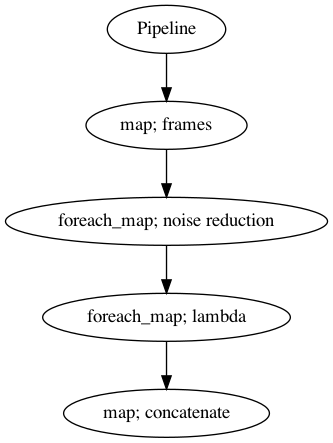

In [10]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 15000, sample_rate = sr)
    .foreach_map(model)
    .foreach_map(lambda x: x['voice'])
    .map(np.concatenate)
)
p.visualize()

In [11]:
%%time

results = p.emit(y)

CPU times: user 33.6 s, sys: 4.16 s, total: 37.8 s
Wall time: 6.67 s


In [12]:
results.keys()

dict_keys(['frames', 'noise-reduction', '<lambda>', 'concatenate'])

In [13]:
ipd.Audio(results['concatenate'][:10 * sr], rate = sr)